In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import math
import seaborn as sns

In [2]:
Test_data = pd.read_csv("test_data.csv")
Train_data = pd.read_csv("train_data.csv")
Train_data


#=============================================================================================
#                             One-Hot Encoding
#-===========================================================================================

Cols = ['parents', 'has_nurs', 'form', 'children', 'housing', 'finance','social', 'health']
Encoded_Training_Data = pd.get_dummies(Train_data.loc[:,Cols],drop_first=True)
Encoded_Testing_Data = pd.get_dummies(Test_data.loc[:,Cols],drop_first=True)

<AxesSubplot:>

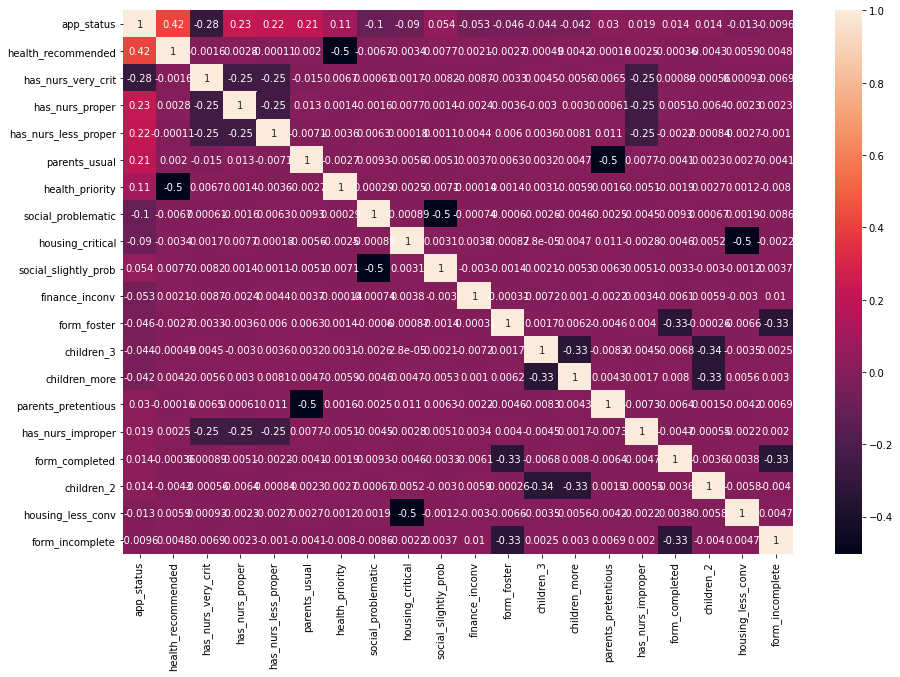

In [3]:
import seaborn as sn
from pandas import DataFrame

data=Encoded_Training_Data
data["app_status"]=Train_data["app_status"]
t=data.columns

s=abs(data[t].corr()['app_status'])
p=s.sort_values(ascending=True)
p.index

t=p.index[::-1]
df = pd.DataFrame(data[t],columns=t)
fig, ax = plt.subplots(figsize=(15,10),sharex=True, sharey=True) 
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True,annot_kws={"size": 10},ax=ax)

In [5]:
p.index[::-1]

Index(['app_status', 'health_recommended', 'has_nurs_very_crit',
       'has_nurs_proper', 'has_nurs_less_proper', 'parents_usual',
       'health_priority', 'social_problematic', 'housing_critical',
       'social_slightly_prob', 'finance_inconv', 'form_foster', 'children_3',
       'children_more', 'parents_pretentious', 'has_nurs_improper',
       'form_completed', 'children_2', 'housing_less_conv', 'form_incomplete'],
      dtype='object')

c:\users\octavei\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\octavei\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\octavei\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit 

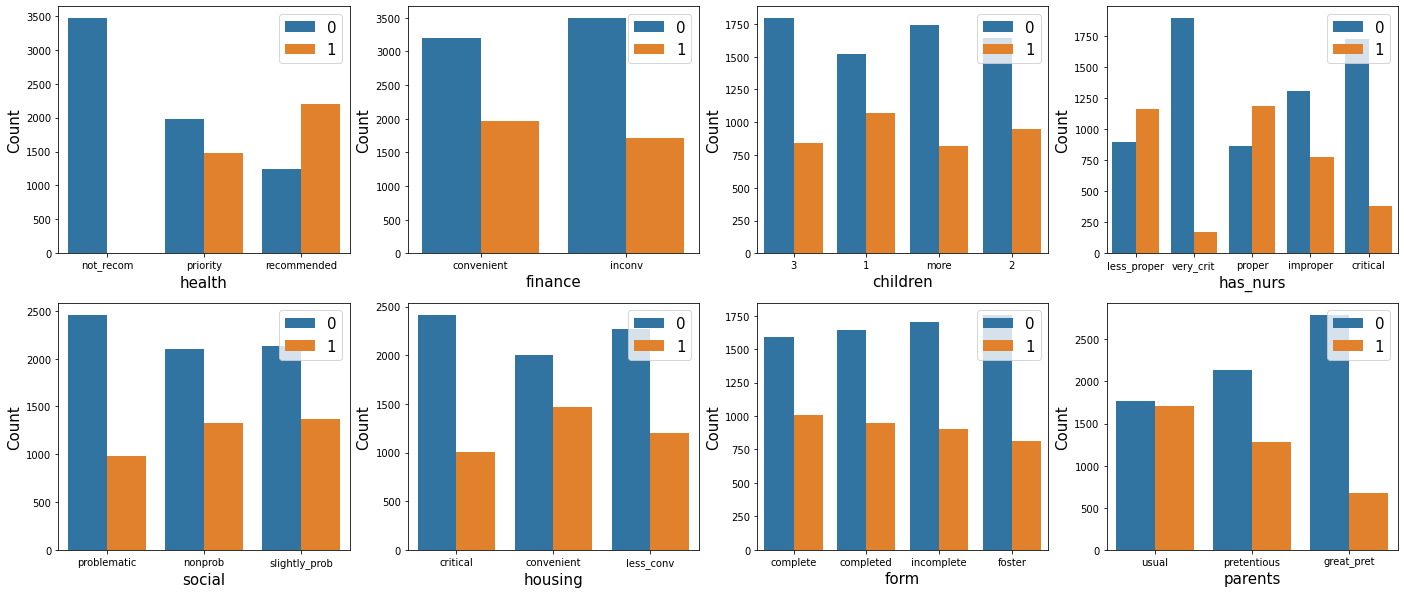

In [6]:
t=['parents', 'has_nurs', 'form', 'children', 'housing', 'finance','social', 'health']
cols=t[::-1]
#make the subplot size
n_cols=4
n_rows=2
fig, axs=plt.subplots(n_rows,n_cols,figsize=(n_cols*6,n_rows*5))
for c in range (n_cols):
    for r in range (n_rows):
        i=c*n_rows + r #index to subplot
        ax = axs[r][c]
        sns.countplot(Train_data[cols[i]],hue=Train_data["app_status"],ax=ax)
        ax.legend(loc="upper right",fontsize=15)
        ax.set_xlabel(cols[i],fontsize=15);
        ax.set_ylabel('Count',fontsize=15);


In [7]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
#=============================================================================================
#                                XGBClassifier
#-===========================================================================================


import xgboost as xgb

X=Encoded_Training_Data.loc[:,['parents_pretentious', 'parents_usual', 'has_nurs_improper',
       'has_nurs_less_proper', 'has_nurs_proper', 'has_nurs_very_crit',
       'form_completed', 'form_foster', 'form_incomplete', 'children_2',
       'children_3', 'children_more', 'housing_critical', 'housing_less_conv',
       'finance_inconv', 'social_problematic', 'social_slightly_prob',
       'health_priority', 'health_recommended']]


y=Train_data.loc[:,["app_status"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)



w_array = y_train["app_status"]*(1- sum(y_train["app_status"])/len(y_train["app_status"]))


# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['max_depth'] = [i for i in range(1, 15)]
space['learning_rate'] = list(np.arange(0.05,1,0.05))
space['subsample'] = [0.7,0.8,0.9,1]
space['sample_weight'] = w_array

# xgb_clf = xgb.XGBClassifier(learning_rate=1, max_depth=12, random_state=1,sample_weight=w_array)

xgb_clf = xgb.XGBClassifier()

# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

# execute search
result = search.fit(X_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


xgb_clf = xgb.XGBClassifier(max_depth = result.best_params_["max_depth"], learning_rate = result.best_params_["learning_rate"],
                            subsample = result.best_params_["subsample"], sample_weight = result.best_params_["sample_weight"],
                            random_state=1)

xgb_clf.fit(X_train,y_train)


print("\n============================================================================================\n")
from sklearn.metrics import confusion_matrix

cm= confusion_matrix(y_test,xgb_clf.predict(X_test))
    
#Extract  TN, FP ,FN, TP
TN, FP ,FN, TP =  cm.ravel()

test_score=(TP+TN)/(TN+ FP +FN+ TP)
#print(cm)
print('xgboostClassifier Training Accuracy = ',xgb_clf.score(X_train,y_train),"\n")
print('xgboostClassifier Testing Accuracy = ',test_score,"\n")
print("\tTP:",TP,"\tFP:",FP,"\n\tTN:",TN,"\tFN:",FN )
print("\n"*2)


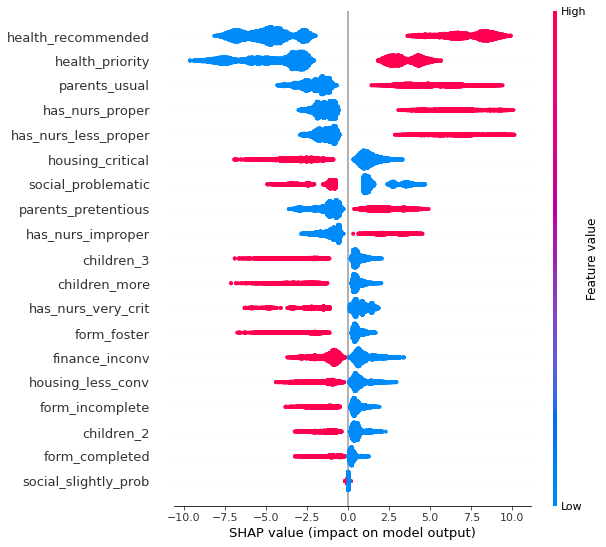

In [7]:
#==================================================================================
#                          XGBRegressor  SHAP explainer 
#==================================================================================
import shap

explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [10]:
Data_point=86
print(y.iloc[Data_point])

shap.initjs()
explainer = shap.Explainer(xgb_clf)
shap_values = explainer(X)
shap.force_plot(shap_values[Data_point])



app_status    0
Name: 86, dtype: int64


In [38]:
X_test=Encoded_Testing_Data.loc[:,['parents_pretentious', 'parents_usual', 'has_nurs_improper',
       'has_nurs_less_proper', 'has_nurs_proper', 'has_nurs_very_crit',
       'form_completed', 'form_foster', 'form_incomplete', 'children_2',
       'children_3', 'children_more', 'housing_critical', 'housing_less_conv',
       'finance_inconv', 'social_problematic', 'social_slightly_prob',
       'health_priority', 'health_recommended']]
Test_data["app_status"]=xgb_clf.predict(X_test)
Test_data

p=Test_data.loc[:,["ID","app_status"]]
p.to_csv("Incognito.csv")

Best Score: 0.9848875841120815
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 14, 'random_state': 0}


Decition Tree Training Accuracy =  0.9971063419339281 

Decition Tree Testing Accuracy =  0.9879459980713597 

	TP: 695 	FP: 15 
	TN: 1354 	FN: 10





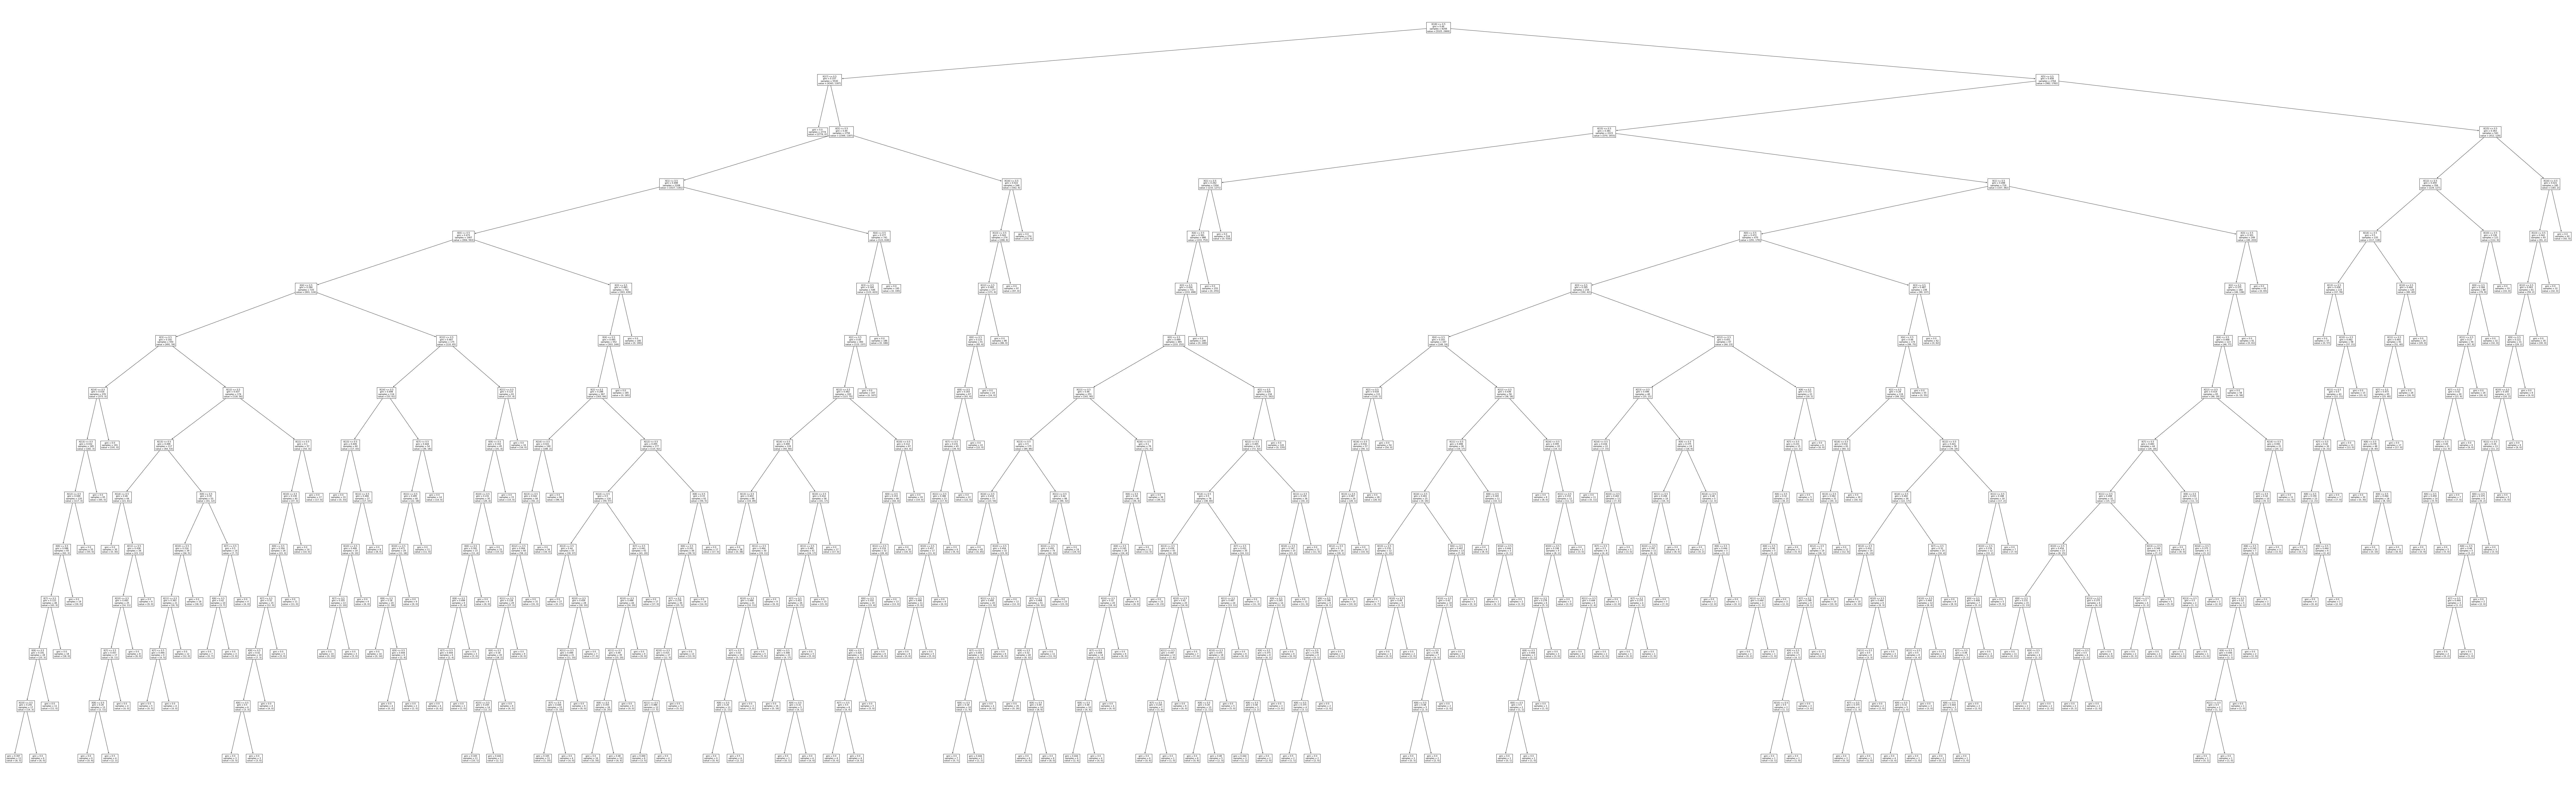

In [22]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier


# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['max_depth'] = [i for i in range(1, 15)]
space['criterion'] = ["gini"]
space['random_state'] = [0]

D_tree = DecisionTreeClassifier()

# define search
search = GridSearchCV(D_tree, space, scoring='accuracy', n_jobs=-1, cv=cv)

X=Encoded_Training_Data.loc[:,['parents_pretentious', 'parents_usual', 'has_nurs_improper',
       'has_nurs_less_proper', 'has_nurs_proper', 'has_nurs_very_crit',
       'form_completed', 'form_foster', 'form_incomplete', 'children_2',
       'children_3', 'children_more', 'housing_critical', 'housing_less_conv',
       'finance_inconv', 'social_problematic', 'social_slightly_prob',
       'health_priority', 'health_recommended']]


y=Train_data.loc[:,["app_status"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=345)

# execute search
result = search.fit(X_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


D_tree = DecisionTreeClassifier( criterion="gini",max_depth = 14, random_state=0)


D_tree.fit(X_train,y_train)


print("\n============================================================================================\n")
from sklearn.metrics import confusion_matrix

cm= confusion_matrix(y_test,D_tree.predict(X_test))
    
#Extract  TN, FP ,FN, TP
TN, FP ,FN, TP =  cm.ravel()

test_score=(TP+TN)/(TN+ FP +FN+ TP)
#print(cm)
print('Decition Tree Training Accuracy = ',D_tree.score(X_train,y_train),"\n")
print('Decition Tree Testing Accuracy = ',test_score,"\n")
print("\tTP:",TP,"\tFP:",FP,"\n\tTN:",TN,"\tFN:",FN )
print("\n"*2)

f, axes = plt.subplots(1, 1,figsize=(80*2.5,25*2.5))
tree.plot_tree(D_tree, ax=axes)
plt.show()


In [27]:
#Use SVC (linear kernel)
from sklearn.svm import SVC

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['kernel'] = ['rbf','poly','sigmoid','linear']
space['C'] = [0.1,1, 6, 8, 10, 20, 100]
space['gamma'] = [1,0.1,0.01,0.001]
space['random_state'] = [0]

svc=SVC()

# define search
search = GridSearchCV(svc, space, scoring='accuracy', n_jobs=-1, cv=cv)

X=Encoded_Training_Data.loc[:,['parents_pretentious', 'parents_usual', 'has_nurs_improper',
       'has_nurs_less_proper', 'has_nurs_proper', 'has_nurs_very_crit',
       'form_completed', 'form_foster', 'form_incomplete', 'children_2',
       'children_3', 'children_more', 'housing_critical', 'housing_less_conv',
       'finance_inconv', 'social_problematic', 'social_slightly_prob',
       'health_priority', 'health_recommended']]


y=Train_data.loc[:,["app_status"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=345)

# execute search
result = search.fit(X_train, y_train)


# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

svc=SVC(C=20, gamma=0.1, kernel='rbf', random_state=0)

svc.fit(X_train,y_train)

print("\n============================================================================================\n")
from sklearn.metrics import confusion_matrix

cm= confusion_matrix(y_test,svc.predict(X_test))
    
#Extract  TN, FP ,FN, TP
TN, FP ,FN, TP =  cm.ravel()

test_score=(TP+TN)/(TN+ FP +FN+ TP)
#print(cm)
print('SVC Training Accuracy = ',svc.score(X_train,y_train),"\n")
print('SVC Testing Accuracy = ',test_score,"\n")
print("\tTP:",TP,"\tFP:",FP,"\n\tTN:",TN,"\tFN:",FN )
print("\n"*2)


c:\users\octavei\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)




SVC Training Accuracy =  1.0 

SVC Testing Accuracy =  1.0 

	TP: 1429 	FP: 0 
	TN: 2719 	FN: 0





In [ ]:
#=============================================================================================
#                                CatBoostClassifier
#-===========================================================================================

from catboost import CatBoostClassifier

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['max_depth'] = [i for i in range(1, 15)]
space['learning_rate'] = list(np.arange(0.1,2,0.1))
space['task_type'] = ['GPU']
space['random_state'] = [0]

cat=CatBoostClassifier()

# define search
search = GridSearchCV(cat, space, scoring='accuracy', n_jobs=-1, cv=cv)

X=Encoded_Training_Data.loc[:,['parents_pretentious', 'parents_usual', 'has_nurs_improper',
       'has_nurs_less_proper', 'has_nurs_proper', 'has_nurs_very_crit',
       'form_completed', 'form_foster', 'form_incomplete', 'children_2',
       'children_3', 'children_more', 'housing_critical', 'housing_less_conv',
       'finance_inconv', 'social_problematic', 'social_slightly_prob',
       'health_priority', 'health_recommended']]
y=Train_data.loc[:,["app_status"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


# execute search
result = search.fit(X_train, y_train)


# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


catb_clf = CatBoostClassifier(learning_rate=2, max_depth=12,task_type="GPU")#task_type="GPU",
catb_clf.fit(X_train,y_train)



print("\n============================================================================================\n")
from sklearn.metrics import confusion_matrix

cm= confusion_matrix(y_test,catb_clf.predict(X_test))
    
#Extract  TN, FP ,FN, TP
TN, FP ,FN, TP =  cm.ravel()

test_score=(TP+TN)/(TN+ FP +FN+ TP)
#print(cm)
print('CatBoostClassifier Training Accuracy = ',catb_clf.score(X_train,y_train),"\n")
print('CatBoostClassifier Testing Accuracy = ',test_score,"\n")
print("\tTP:",TP,"\tFP:",FP,"\n\tTN:",TN,"\tFN:",FN )
print("\n"*2)


In [6]:
# Training model

def models(X_train,Y_train):
    
    #Use Logistic Regression
    from sklearn.linear_model import LogisticRegression
    log = LogisticRegression(random_state = 0,solver='lbfgs')
    log.fit(X_train,Y_train)
    
    #Use Kneighbors
    from sklearn.neighbors import KNeighborsClassifier
    knn=KNeighborsClassifier(n_neighbors = 5,metric="minkowski",p=2)
    knn.fit(X_train,Y_train)
    
    #Use SVC (linear kernel)
    from sklearn.svm import SVC
    svc_lin=SVC(kernel="linear",random_state=0)
    svc_lin.fit(X_train,Y_train)
    
    #Use SVC (RBF kernel)
    from sklearn.svm import SVC
    svc_rbf=SVC(kernel="rbf",gamma='auto',random_state=0)
    svc_rbf.fit(X_train,Y_train)
    
    #Use GaussianNB
    from sklearn.naive_bayes import GaussianNB
    gauss = GaussianNB()
    gauss.fit(X_train,Y_train)
    
    #Use Decision Tree
    from sklearn.tree import DecisionTreeClassifier
    tree = DecisionTreeClassifier( criterion="entropy" ,random_state=Data_pointData_pointData_pointData_pointData_pointData_pointData_pointData_pointData_pointData_pointData_pointData_pointData_pointData_pointData_pointData_pointData_pointData_point0)
    tree.fit(X_train,Y_train)
    
    #Use Random Forest Classifier
    from sklearn.ensemble import RandomForestClassifier
    forest = RandomForestClassifier(n_estimators=100,criterion="entropy",random_state=0)
    forest.fit(X_train,Y_train)
    
    #Use XGBClassifier
    import xgboost as xgb
    modelx=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
    modelx.fit(X_train,Y_train)
    
    #Use ExtraTreesClassifier
    from sklearn.ensemble import ExtraTreesClassifier
    ExtraTree=ExtraTreesClassifier(n_estimators=100, max_depth=None,min_samples_split=2, random_state=8)
    ExtraTree.fit(X_train,Y_train)
    
    #use AdaBoostClassifier
    from sklearn.ensemble import AdaBoostClassifier
    AdaBoost = AdaBoostClassifier(n_estimators=100)
    AdaBoost.fit(X_train,Y_train)
    
    #print the accuracy of each model
    print("[0] Logistic Regression Training Accuracy: ",log.score(X_train,Y_train))
    print("[1] K Neighbors Regression Training Accuracy: ",knn.score(X_train,Y_train))
    print("[2] SVC Linear Training Accuracy: ",svc_lin.score(X_train,Y_train))
    print("[3] SVC RBF Training Accuracy: ",svc_rbf.score(X_train,Y_train))
    print("[4] Gaussian NB Training Accuracy: ",gauss.score(X_train,Y_train))
    print("[5] Decision Tree Training Accuracy: ",tree.score(X_train,Y_train))
    print("[6] Random Forest Training Accuracy: ",forest.score(X_train,Y_train))
    print("[7] XGBClassifier Training Accuracy: ",modelx.score(X_train,Y_train))
    print("[8] ExtraTreesClassifier Training Accuracy: ",ExtraTree.score(X_train,Y_train))
    print("[9] AdaBoostClassifierr Training Accuracy: ",AdaBoost.score(X_train,Y_train))
    
    
    return  log,knn, svc_lin, svc_rbf, gauss, tree, forest,modelx,ExtraTree,AdaBoost

In [7]:

Data=Encoded_Training_Data
Data["app_status"]=Train_data.loc[:,["app_status"]]


p=['parents_pretentious', 'parents_usual', 'has_nurs_improper',
       'has_nurs_less_proper', 'has_nurs_proper', 'has_nurs_very_crit',
       'form_completed', 'form_foster', 'form_incomplete', 'children_2',
       'children_3', 'children_more', 'housing_critical', 'housing_less_conv',
       'finance_inconv', 'social_problematic', 'social_slightly_prob',
       'health_priority', 'health_recommended']

subdata = Data.loc[:,p+["app_status"]]
subData=subdata.dropna(subset=p)

X=subData.loc[:,p]
Y=subData.loc[:,["app_status"]]

# Train and test set 80% : 20%
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=4)
Y_train = np.array(np.ravel(Y_train)).astype(int)


print("\n============================================================================================")
print("Only considering",p,"\nsize =",len(subData))
print("============================================================================================\n\n")


model = models(X_train,Y_train)
ms=["Logistic Regression","K Neighbors","SVC Linear","SVC RBF","Gaussian NB","Decision Tree","Random Forest",
    "XGBClassifier","ExtraTreesClassifier","AdaBoostClassifierr"]

print("\n============================================================================================\n")
from sklearn.metrics import confusion_matrix
for i in range (len(model)):
    cm= confusion_matrix(Y_test,model[i].predict(X_test))
    
    #Extract  TN, FP ,FN, TP
    TN, FP ,FN, TP =  cm.ravel()
    
    test_score=(TP+TN)/(TN+ FP +FN+ TP)
    #print(cm)
    print(ms[i],'Testing Accuracy = ',test_score,"\n")
    print("\tTP:",TP,"\tFP:",FP,"\n\tTN:",TN,"\tFN:",FN )
    print("\n"*2)


Only considering ['parents_pretentious', 'parents_usual', 'has_nurs_improper', 'has_nurs_less_proper', 'has_nurs_proper', 'has_nurs_very_crit', 'form_completed', 'form_foster', 'form_incomplete', 'children_2', 'children_3', 'children_more', 'housing_critical', 'housing_less_conv', 'finance_inconv', 'social_problematic', 'social_slightly_prob', 'health_priority', 'health_recommended'] 
size = 10368




c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:07:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0] Logistic Regression Training Accuracy:  0.9406800096455269
[1] K Neighbors Regression Training Accuracy:  0.9680491921871233
[2] SVC Linear Training Accuracy:  0.9445382204002893
[3] SVC RBF Training Accuracy:  0.9732336628888353
[4] Gaussian NB Training Accuracy:  0.7700747528333736
[5] Decision Tree Training Accuracy:  1.0
[6] Random Forest Training Accuracy:  1.0
[7] XGBClassifier Training Accuracy:  0.9297082228116711
[8] ExtraTreesClassifier Training Accuracy:  1.0
[9] AdaBoostClassifierr Training Accuracy:  0.9336870026525199


Logistic Regression Testing Accuracy =  0.9305689488910318 

	TP: 667 	FP: 67 
	TN: 1263 	FN: 77



K Neighbors Testing Accuracy =  0.943105110896